In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn import datasets

from bokeh.plotting import *
from bokeh.models import ColumnDataSource

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

## handwritten digits: t-SNE and clustering

In [2]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
X.shape

(1797, 64)

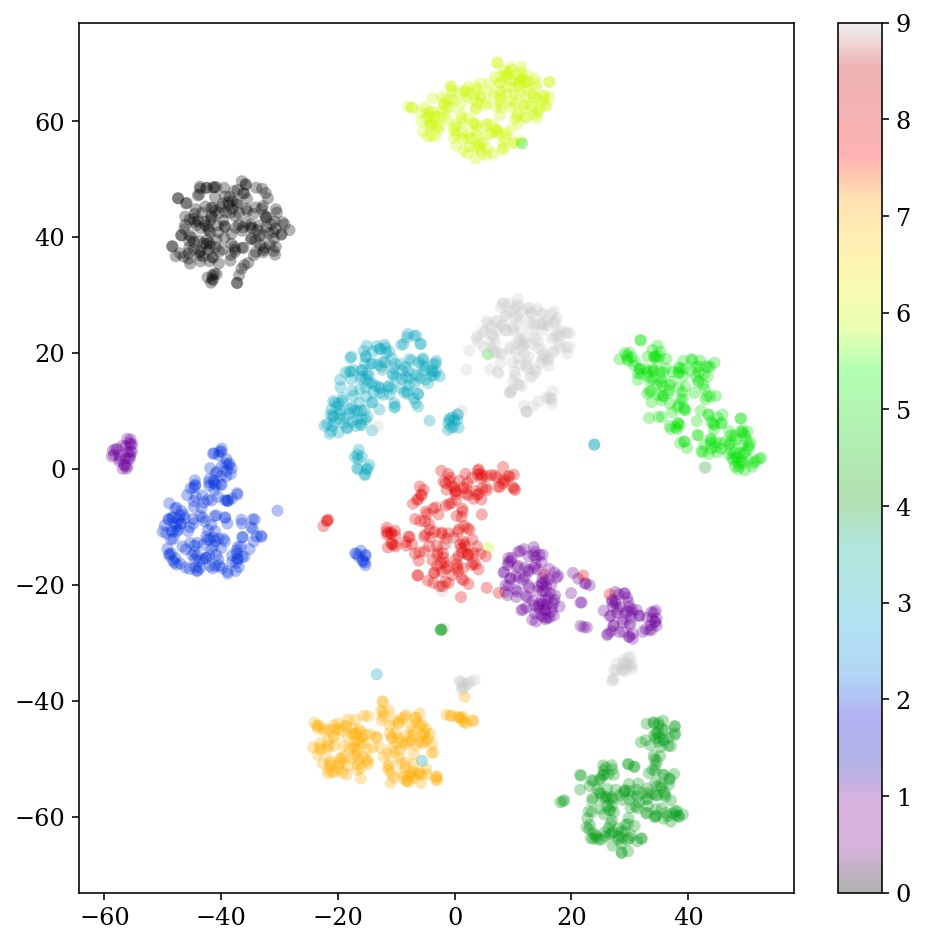

In [3]:
tsne = TSNE(n_components=2,learning_rate=200)
X_reduced = tsne.fit_transform(X)
plt.scatter(X_reduced[:,0],X_reduced[:,1], 
            c=y, cmap="nipy_spectral", alpha=0.3, 
            edgecolor="None")
plt.colorbar()
plt.show()

In [4]:
#Kmeans
n_clusters = len(np.unique(y))
clf = KMeans(n_clusters = n_clusters)
clf.fit(X_reduced)

KMeans(n_clusters=10)

In [5]:
centers = clf.cluster_centers_ 
labels = clf.predict(X_reduced)

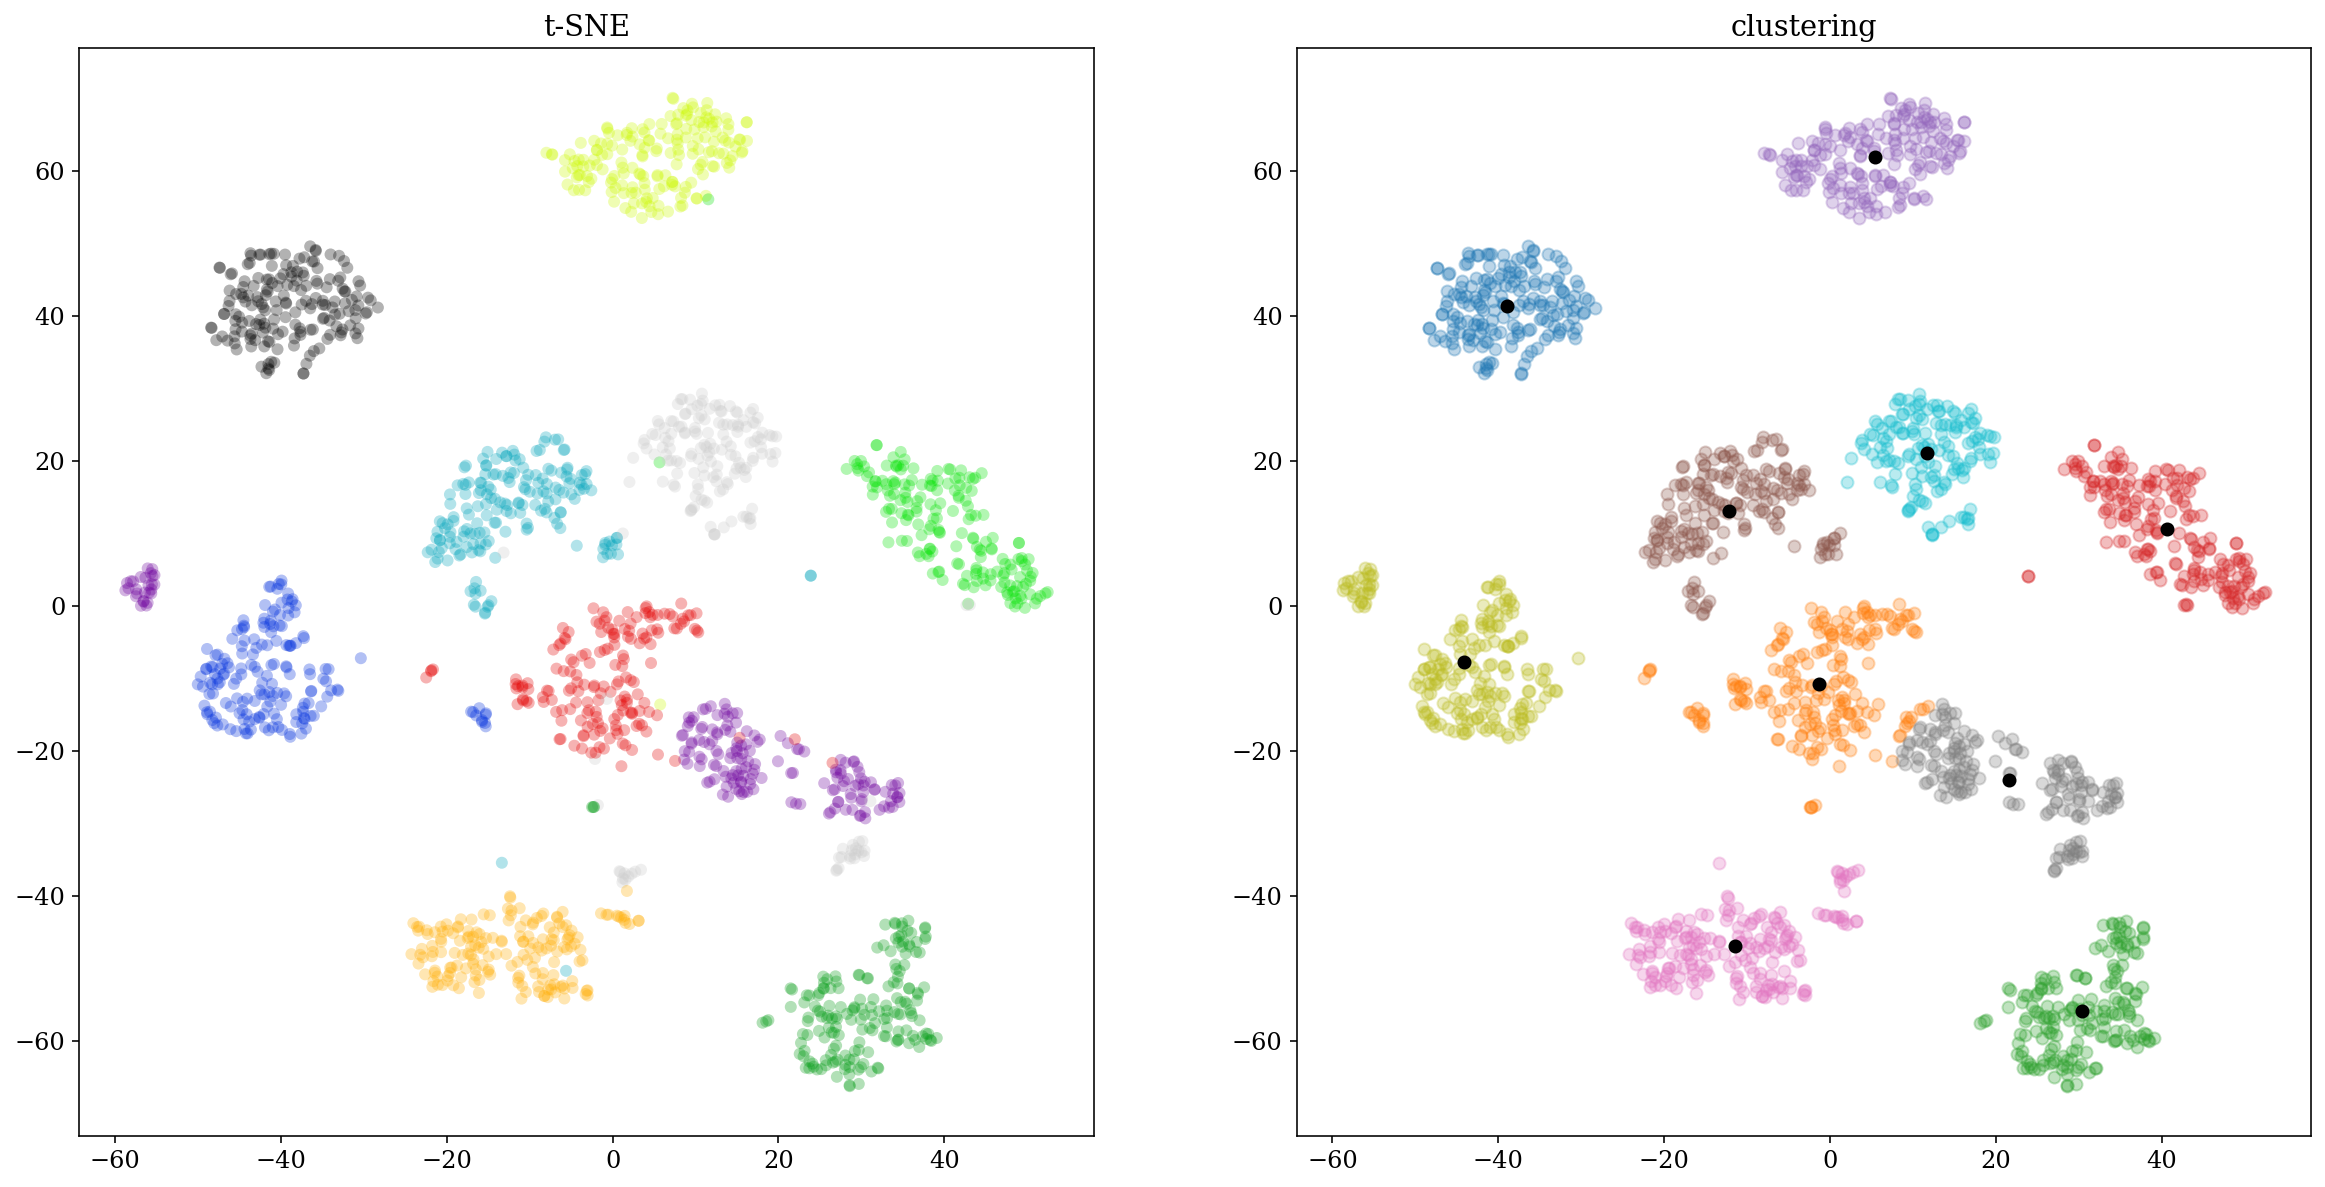

In [6]:
fig = plt.figure(figsize = (20, 10))
ax1 = plt.subplot(121)
ax1.scatter(X_reduced[:,0],X_reduced[:,1], 
            c=y, cmap="nipy_spectral", alpha=0.3, 
            edgecolor="None")
ax1.set_title('t-SNE')

ax2 = plt.subplot(122)
for i in range(n_clusters):
    ax2.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], alpha = 0.3)
ax2.scatter(centers[:, 0], centers[:, 1], c='k')
ax2.set_title('clustering')
plt.show()

the clustering algorithm has found more or less all the blobs

## bokeh visualization

In [7]:
#GRB data
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [8]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [33]:
mask = (data[6].astype('float') > 0) & (data[7].astype('float') > 0) & (data[9].astype('float') > 0) & (data[10].astype('float') > 0) & (data[11].astype('float') > 0)

names = data[0][mask]
ra, dec = data[3].astype('float')[mask], data[4].astype('float')[mask]
T90, T90_error = np.log10(data[6].astype('float')[mask]), np.log10(data[7].astype('float')[mask])
fluence, fluence_error = np.log10(data[9].astype('float')[mask]), np.log10(data[10].astype('float')[mask])
z = data[11].astype('float')[mask]

output_file("linked_brushing.html")

In [36]:
from bokeh.plotting import *
from bokeh.models import ColumnDataSource

# output to static HTML file
output_file("linked_brushing.html")

# NEW: create a column data source for the plots to share
source = ColumnDataSource(data=dict(names=names, ra=ra, dec=dec, T90=T90, T90_error=T90_error, fluence=fluence, fluence_error=fluence_error, z=z))

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select"

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("name", "@names"),
]

# left plot: ra-dec
left = figure(tools=TOOLS, tooltips=TOOLTIPS, 
              width=350, height=350, title=None,
              x_axis_label ="ra",
              y_axis_label ="dec",
             )
left.circle('ra', 'dec', source=source)

# right plots: data
right_1 = figure(tools=TOOLS, tooltips=TOOLTIPS, 
               width=350, height=350, title=None,
              x_axis_label ="log(T90 [s])",
               y_axis_label ="log(fluence)")
right_1.circle('T90', 'fluence', source=source)
#---
right_2 = figure(tools=TOOLS, tooltips=TOOLTIPS, 
               width=350, height=350, title=None,
              x_axis_label ="z",
               y_axis_label ="log(fluence)")
right_2.circle('z', 'fluence', source=source)
#---
right_3 = figure(tools=TOOLS, tooltips=TOOLTIPS, 
               width=350, height=350, title=None,
              x_axis_label ="z",
               y_axis_label ="log(T90 [s])")
right_3.circle('z', 'T90', source=source)

# put the subplots in a gridplot
p = gridplot([[left, right_1, right_2, right_3]])

# show the results
show(p,browser="firefox")